# Baseline Classification Models

In [1]:
import numpy as np # Use version 1.x not 2.x
import random
import pandas as pd

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [2]:
import pickle

def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    records = []
    for company, periods in data.items():
        for period, (features, rating) in periods.items():
            record = {
                'company': company,
                'period': period,
                **{f'feature_{i}': feature.item() for i, feature in enumerate(features)},
                'rating': int(rating.item())
            }
            records.append(record)

    return pd.DataFrame(records)

In [3]:
# needed for XGBoost
def encode_labels(y_train, y_test):
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    
    test_labels = np.unique(y_test)
    new_labels = np.setdiff1d(test_labels, label_encoder.classes_)
    if new_labels.size > 0:
        label_encoder.classes_ = np.append(label_encoder.classes_, new_labels)
    
    y_test_encoded = label_encoder.transform(y_test)
    
    return y_train_encoded, y_test_encoded

In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

train_df = load_data('./data/train_dict.pkl')
test_df = load_data('./data/test_dict.pkl')

X_train = train_df.drop(columns=['company', 'period', 'rating'])
y_train = train_df['rating']
X_test = test_df.drop(columns=['company', 'period', 'rating'])
y_test = test_df['rating']

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train, y_test = encode_labels(y_train, y_test)

In [5]:
train_df.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,rating
count,13419.000000,13419.000000,13419.000000,13419.000000,13419.000000,13419.000000,13419.000000,13419.000000,13419.000000,13419.000000,...,13419.000000,13419.000000,13419.000000,13419.000000,13419.000000,13419.000000,13419.000000,13419.000000,13419.000000,13419.00000
mean,3.810639,4.239910,3.958005,4.658519,4.193749,4.022636,5.490030,3.910604,4.253997,3.846538,...,-0.038140,-0.917355,-0.078312,-0.083236,0.055194,-0.029182,0.332568,-0.558261,1.797081,9.54706
std,11.431498,11.293457,10.779591,16.127461,13.029752,12.897926,17.574325,8.844879,10.974842,12.296666,...,4.323687,51.917468,0.594742,0.663512,0.680137,129.240364,1.876188,91.322609,7.384274,3.16827
min,-0.308304,-0.266087,-0.294602,-0.289814,-0.295400,-0.205454,-0.277362,-0.203393,-0.226853,-215.762192,...,-271.892731,-4882.298340,-1.141994,-1.142238,-0.532463,-12999.674805,-40.224262,-9938.629883,-0.649376,0.00000
25%,0.227744,0.298246,0.302132,0.028129,0.251324,0.096226,0.246125,0.368439,0.365536,0.053331,...,-0.418189,-0.239244,-0.477208,-0.504659,-0.359399,0.006327,-0.201479,-0.250107,-0.154979,7.00000
50%,0.946296,1.023283,1.014643,0.719754,0.949407,0.884547,1.066430,1.104624,1.105655,0.937856,...,0.020812,0.160447,-0.199570,-0.172257,-0.130685,0.410631,0.193717,0.177438,0.161311,10.00000
75%,2.658684,3.832452,3.462913,2.845509,2.915207,2.805770,3.686272,3.565986,3.727190,3.505346,...,0.471509,0.613430,0.204816,0.191851,0.218999,1.221484,0.748354,0.701961,0.956126,12.00000
max,160.789398,152.580627,150.960022,289.723022,199.850311,197.842560,233.938110,100.602760,137.974792,245.519623,...,204.916534,1640.114136,4.421368,6.690714,9.021321,4006.946289,30.412418,697.988953,569.232544,22.00000


In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_SEED),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED),
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=RANDOM_SEED),
    'k-NN (k=1)': KNeighborsClassifier(n_neighbors=1),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(random_state=RANDOM_SEED),
    'LDA': LinearDiscriminantAnalysis(),
    'XGBoost': xgb.XGBClassifier(eval_metric='mlogloss', random_state=RANDOM_SEED),
    'LightGBM': lgb.LGBMClassifier(random_state=RANDOM_SEED, verbose = -1)
}

print('Train-Test Split Accuracy Results')
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name:20}: {accuracy:.4f}')

Train-Test Split Accuracy Results
Decision Tree       : 0.1415
Random Forest       : 0.1775
Logistic Regression : 0.2117
k-NN (k=1)          : 0.1397
Naive Bayes         : 0.1057
SVM                 : 0.1839
LDA                 : 0.1402
XGBoost             : 0.1813
LightGBM            : 0.1221


#### Class Distribution

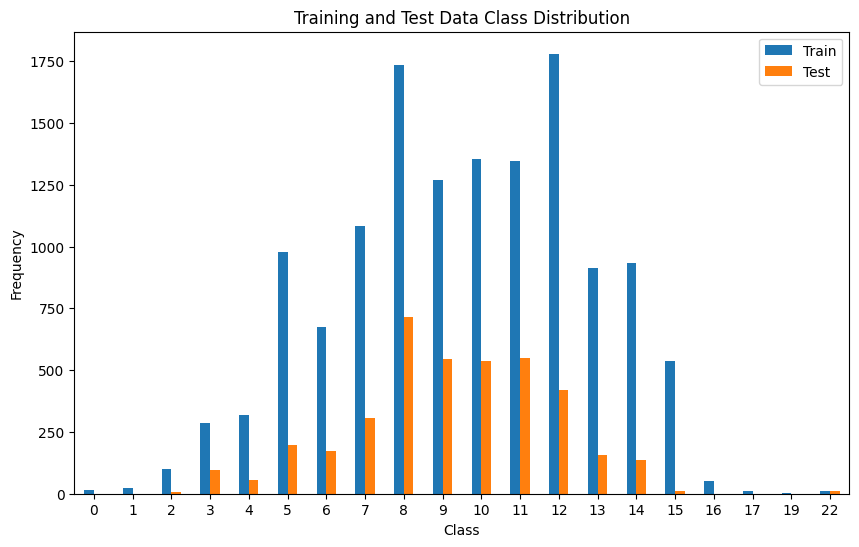

In [7]:
import matplotlib.pyplot as plt

def plot_class_distribution(y_train, y_test, title):
    plt.figure(figsize=(10, 6))
    train_counts = y_train.value_counts().sort_index()
    test_counts = y_test.value_counts().sort_index()
    
    df_plot = pd.DataFrame({'Train': train_counts, 'Test': test_counts}).fillna(0)
    df_plot.plot(kind='bar', ax=plt.gca())
    
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(rotation=0)
    plt.legend(['Train', 'Test'])
    plt.show()

plot_class_distribution(train_df['rating'], test_df['rating'], 'Training and Test Data Class Distribution')

In [8]:
from scipy.stats import chi2_contingency

train_label_counts = train_df['rating'].value_counts()
test_label_counts = test_df['rating'].value_counts()

observed = pd.DataFrame({'Train': train_label_counts, 'Test': test_label_counts}).fillna(0)
chi2, p, dof, expected = chi2_contingency(observed.T)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

if p < 0.05:
    print("The difference in class distributions between training and test datasets is statistically significant.")
else:
    print("The difference in class distributions between training and test datasets is not statistically significant.")


Chi-square statistic: 542.880692116998
P-value: 5.474432886505517e-103
The difference in class distributions between training and test datasets is statistically significant.


#### Feature Distributrion

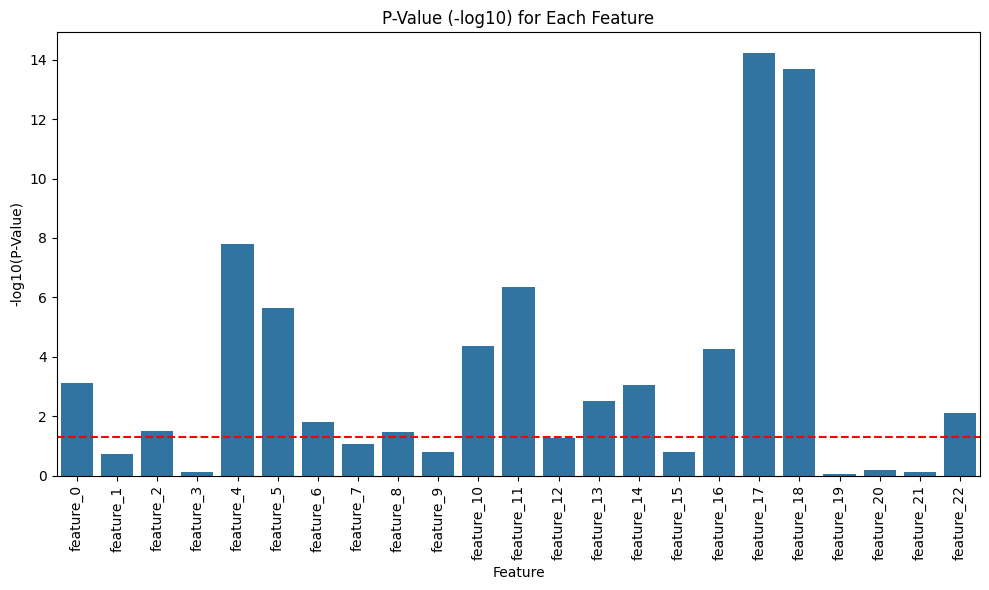

In [9]:
from scipy.stats import ttest_ind
import pandas as pd
import seaborn as sns

numeric_features = train_df.select_dtypes(include=['float64']).columns

t_test_results = []

for feature in numeric_features:
    t_stat, p_value = ttest_ind(train_df[feature], test_df[feature])
    t_test_results.append({'feature': feature, 't_statistic': t_stat, 'p_value': p_value})

t_test_df = pd.DataFrame(t_test_results)

t_test_df['-log10(p_value)'] = -np.log10(t_test_df['p_value'])

plt.figure(figsize=(10, 6))

sns.barplot(x='feature', y='-log10(p_value)', data=t_test_df)
plt.axhline(-np.log10(0.05), color='red', linestyle='--')
plt.xticks(rotation=90)
plt.title('P-Value (-log10) for Each Feature')
plt.xlabel('Feature')
plt.ylabel('-log10(P-Value)')

plt.tight_layout()
plt.show()

### Predict newer data (20%) from older data (80%)

In [10]:
def split_by_period(df):
    split_index = int(len(df) * 0.8)
    train_data = df.iloc[:split_index]
    test_data = df.iloc[split_index:]
    return train_data, test_data

merged_df = pd.concat([train_df, test_df], ignore_index=True)
merged_df = merged_df.sort_values(by=['company', 'period'])

train_df = pd.DataFrame()
test_df = pd.DataFrame()

for company, group in merged_df.groupby('company'):
    train_data, test_data = split_by_period(group)
    train_df = pd.concat([train_df, train_data])
    test_df = pd.concat([test_df, test_data])

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [11]:
train_df.iloc[41:46]

,company,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,rating
41,AAL,2020Q2,9.358152,20.610624,16.032759,30.888725,6.761358,3.559145,21.061703,29.293434,...,-8.993368,-14.530337,-0.707366,-0.522562,0.225215,-14.396945,-2.791513,10.533374,0.934059,12
42,AAL,2020Q3,8.340997,20.478172,15.584459,26.190260,7.776797,3.513597,19.382196,30.482496,...,-4.068741,-8.808525,-0.722517,-0.550122,0.165980,-8.626437,-3.491277,6.862294,1.184092,12
43,AAL,2020Q4,7.467043,20.675615,15.390813,22.217646,7.848329,3.470326,19.364405,30.831976,...,-2.642344,-6.427341,-0.773885,-0.620862,0.061735,-7.137291,-3.521091,4.897902,1.222114,12
44,AAL,2021Q1,12.376627,20.530413,17.071869,44.420910,8.754915,3.570533,20.270578,34.958687,...,-3.286706,-3.899826,-0.515904,-0.258778,0.595875,-6.887997,-1.521122,2.209769,1.375260,12
45,AAP,2010Q1,1.098972,0.218212,0.505274,0.111622,1.057709,3.769933,1.725678,0.031290,...,0.855467,0.205086,-0.413703,-1.014619,-0.429032,0.493377,0.415742,1.222719,-0.361857,10


In [12]:
test_df.head()

,company,period,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,rating
0,AAL,2021Q2,15.576209,20.224787,18.037573,56.781490,10.118683,3.868877,25.237936,34.572418,...,-0.926600,-0.427103,-0.509899,-0.238318,0.627533,-7.407228,-0.421442,-0.477901,1.509752,12
1,AAL,2021Q3,13.153007,19.988266,17.018206,46.270180,11.286515,4.010077,22.174259,33.579163,...,-0.650341,-0.245818,-0.536629,-0.289740,0.542962,-7.247670,-0.295384,-0.820659,1.671445,12
2,AAL,2021Q4,11.848042,19.942608,16.519533,40.132053,12.151116,3.882541,22.254913,32.312370,...,-0.729365,-1.547125,-0.606601,-0.384312,0.397845,-7.153681,-1.279906,1.699241,1.922507,12
3,AAL,2022Q1,12.147082,20.151567,16.755960,40.177231,12.574086,4.353971,25.647139,32.118938,...,-1.072615,-2.484440,-0.675459,-0.477723,0.277068,-6.182828,-1.881923,2.639538,1.734946,12
4,AAL,2022Q2,12.682686,20.068888,16.898220,40.427216,15.150783,4.971155,26.719366,31.608664,...,-0.267140,-0.063466,-0.674590,-0.484475,0.249731,-6.522480,-0.030636,-1.386750,1.871140,12


In [13]:
X_train = train_df.drop(columns=['company', 'period', 'rating'])
y_train = train_df['rating']
X_test = test_df.drop(columns=['company', 'period', 'rating'])
y_test = test_df['rating']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train, y_test = encode_labels(y_train, y_test)

print('Predict newer data (20%) from older data (80%) \nAccuracy Results')
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name:20}: {accuracy:.4f}')

Predict newer data (20%) from older data (80%) 
Accuracy Results
Decision Tree       : 0.5082
Random Forest       : 0.7278
Logistic Regression : 0.3007
k-NN (k=1)          : 0.5981
Naive Bayes         : 0.1524
SVM                 : 0.3695
LDA                 : 0.2467
XGBoost             : 0.6913
LightGBM            : 0.2459


### Predict the most recent ratings from all past data

In [14]:
merged_df = pd.concat([train_df, test_df], ignore_index=True)
merged_df = merged_df.sort_values(by=['company', 'period'])

train_df = pd.DataFrame()
test_df = pd.DataFrame()

for company, group in merged_df.groupby('company'):
    test_data = group.iloc[-1:]
    train_data = group.iloc[:-1]
    train_df = pd.concat([train_df, train_data])
    test_df = pd.concat([test_df, test_data])

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [15]:
print(len(test_df))
print(merged_df['company'].nunique())

346
346


In [16]:
X_train = train_df.drop(columns=['company', 'period', 'rating'])
y_train = train_df['rating']
X_test = test_df.drop(columns=['company', 'period', 'rating'])
y_test = test_df['rating']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train, y_test = encode_labels(y_train, y_test)

print('Predict the most recent ratings from all past data \nAccuracy Results')
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name:20}: {accuracy:.4f}')

Predict the most recent ratings from all past data 
Accuracy Results
Decision Tree       : 0.7197
Random Forest       : 0.9422
Logistic Regression : 0.3006
k-NN (k=1)          : 0.8035
Naive Bayes         : 0.1561
SVM                 : 0.3960
LDA                 : 0.2543
XGBoost             : 0.9075
LightGBM            : 0.2572


### Appendix: Cross-Validation

#### split by companies (GroupKFold)

In [17]:
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline

merged_df = pd.concat([train_df, test_df], ignore_index=True)

X = merged_df.drop(columns=['company', 'period', 'rating'])
y = merged_df['rating']

groups = merged_df['company']

gkf = GroupKFold(n_splits=5)
print('GroupKFold (5-Fold Cross-Validation) Accuracy Results')

for model_name, model in models.items():
    fold_accuracies = []
    
    for train_index, test_index in gkf.split(X, y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        y_train, y_test = encode_labels(y_train, y_test)
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        pipeline.fit(X_train, y_train)
        
        accuracy = pipeline.score(X_test, y_test)
        fold_accuracies.append(accuracy)
    
    print(f'{model_name:20}: {np.mean(fold_accuracies):.4f}')

GroupKFold (5-Fold Cross-Validation) Accuracy Results
Decision Tree       : 0.1516
Random Forest       : 0.1687
Logistic Regression : 0.1830
k-NN (k=1)          : 0.1464
Naive Bayes         : 0.1183
SVM                 : 0.1716
LDA                 : 0.1335
XGBoost             : 0.1694
LightGBM            : 0.0983


#### split by companies (StratifiedGroupKFold)

In [18]:
from sklearn.model_selection import StratifiedGroupKFold

merged_df = pd.concat([train_df, test_df], ignore_index=True)

X = merged_df.drop(columns=['company', 'period', 'rating'])
y = merged_df['rating']

groups = merged_df['company']

sgkf = StratifiedGroupKFold()
print('StratifiedGroupKFold (5-Fold Cross-Validation) Accuracy Results')

for model_name, model in models.items():
    fold_accuracies = []
    
    for train_index, test_index in sgkf.split(X, y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        y_train, y_test = encode_labels(y_train, y_test)
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        pipeline.fit(X_train, y_train)
        
        accuracy = pipeline.score(X_test, y_test)
        fold_accuracies.append(accuracy)
    
    print(f'{model_name:20}: {np.mean(fold_accuracies):.4f}')

StratifiedGroupKFold (5-Fold Cross-Validation) Accuracy Results


c:\Users\Ryo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Decision Tree       : 0.1446


c:\Users\Ryo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Random Forest       : 0.1776


c:\Users\Ryo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Logistic Regression : 0.1924


c:\Users\Ryo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


k-NN (k=1)          : 0.1533


c:\Users\Ryo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Naive Bayes         : 0.1146


c:\Users\Ryo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


SVM                 : 0.1971


c:\Users\Ryo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


LDA                 : 0.1695


c:\Users\Ryo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


XGBoost             : 0.1836


c:\Users\Ryo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


LightGBM            : 0.1291


#### shuffle/split by periods (data leakage?)

In [22]:
from sklearn.model_selection import KFold, cross_val_score

merged_df = pd.concat([train_df, test_df], ignore_index=True)

X = merged_df.drop(columns=['company', 'period', 'rating'])
y = merged_df['rating']

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
print('5-Fold Cross-Validation (with shuffle) Accuracy Results')

for model_name, model in models.items():
    fold_accuracies = []
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        y_train, y_test = encode_labels(y_train, y_test)
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        pipeline.fit(X_train, y_train)
        
        accuracy = pipeline.score(X_test, y_test)
        fold_accuracies.append(accuracy)
    
    print(f'{model_name:20}: {np.mean(fold_accuracies):.4f}')

5-Fold Cross-Validation (with shuffle) Accuracy Results
Decision Tree       : 0.7620
Random Forest       : 0.9188
Logistic Regression : 0.2791
k-NN (k=1)          : 0.7385
Naive Bayes         : 0.1413
SVM                 : 0.3575
LDA                 : 0.2324
XGBoost             : 0.9036
LightGBM            : 0.3484
